## import

In [46]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers

from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.deeplabv3 import DeepLabV3

from tqdm import tqdm

# setting

In [47]:
artifacts_path = Path("../../artifacts/deeplabv3")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [48]:
DEVICE = torch.device("cuda:0")

# data

In [49]:
BATCH_SIZE = 32
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [50]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [51]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [52]:
NUM_WORKERS = get_num_workers()

In [53]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

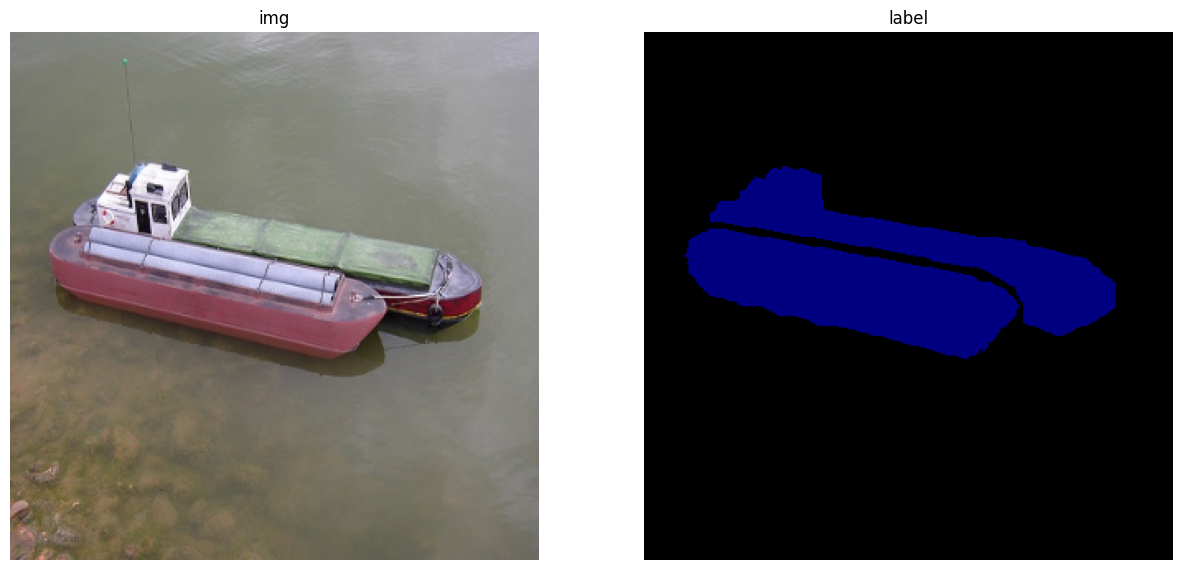

In [54]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [55]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([32, 3, 321, 321])
torch.Size([32, 321, 321])


# train

In [56]:
model = DeepLabV3(
    output_size=NUM_CLASS + 1,
    backbone_name="resnet101",
    neck_type="parallel",
    frozen_backbone=True,
).to(DEVICE)

In [57]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
DeepLabV3                                               --
├─ResNetFeatureExtractor: 1-1                           --
│    └─Sequential: 2-1                                  --
│    │    └─Sequential: 3-1                             (9,536)
│    │    └─Sequential: 3-2                             (215,808)
│    │    └─Sequential: 3-3                             (1,219,584)
│    │    └─Sequential: 3-4                             (26,090,496)
│    │    └─Sequential: 3-5                             (14,964,736)
│    │    └─AdaptiveAvgPool2d: 3-6                      --
│    └─ImageNetNormalization: 2-2                       --
├─ASPP: 1-2                                             --
│    └─ModuleList: 2-3                                  --
│    │    └─Conv2dNormActivation: 3-7                   524,800
│    │    └─Conv2dNormActivation: 3-8                   4,719,104
│    │    └─Conv2dNormActivation: 3-9                   4

In [58]:
EPOCHS = 30

In [59]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)

In [60]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [62]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 91/91 [01:16<00:00,  1.19it/s]


epoch 1 : 0.02048149352872765


100%|██████████| 91/91 [01:15<00:00,  1.20it/s]


epoch 2 : 0.009274594168496


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 3 : 0.007605276515727843


100%|██████████| 91/91 [01:13<00:00,  1.24it/s]


epoch 4 : 0.006812411943798537


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 5 : 0.0060923563081075206


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


epoch 6 : 0.0057180625294427296


100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


epoch 7 : 0.005402887869462534


100%|██████████| 91/91 [01:15<00:00,  1.21it/s]


epoch 8 : 0.005129510958955347


100%|██████████| 91/91 [01:17<00:00,  1.17it/s]


epoch 9 : 0.004896079875774436


100%|██████████| 91/91 [01:13<00:00,  1.24it/s]


epoch 10 : 0.004740014083806303


100%|██████████| 91/91 [01:12<00:00,  1.26it/s]


epoch 11 : 0.00459237923528385


100%|██████████| 91/91 [01:12<00:00,  1.25it/s]


epoch 12 : 0.00447498841446589


100%|██████████| 91/91 [01:12<00:00,  1.26it/s]


epoch 13 : 0.004310002987999674


100%|██████████| 91/91 [01:13<00:00,  1.23it/s]


epoch 14 : 0.004154606489464641


100%|██████████| 91/91 [01:14<00:00,  1.23it/s]


epoch 15 : 0.004007066044813165


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 16 : 0.003977453228659355


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 17 : 0.003960200421675876


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 18 : 0.0036953820458070917


100%|██████████| 91/91 [01:15<00:00,  1.21it/s]


epoch 19 : 0.0035409036087342997


100%|██████████| 91/91 [01:15<00:00,  1.20it/s]


epoch 20 : 0.0034629535544049607


100%|██████████| 91/91 [01:12<00:00,  1.25it/s]


epoch 21 : 0.0033959834580565545


100%|██████████| 91/91 [01:13<00:00,  1.24it/s]


epoch 22 : 0.0033412289416806383


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 23 : 0.003314774491118042


100%|██████████| 91/91 [01:16<00:00,  1.19it/s]


epoch 24 : 0.003248508797016936


100%|██████████| 91/91 [01:15<00:00,  1.20it/s]


epoch 25 : 0.0032591376259186113


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 26 : 0.003241540557080573


100%|██████████| 91/91 [01:14<00:00,  1.21it/s]


epoch 27 : 0.0032372654282620977


100%|██████████| 91/91 [01:15<00:00,  1.21it/s]


epoch 28 : 0.003233050712599204


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


epoch 29 : 0.003225060932051677


100%|██████████| 91/91 [01:14<00:00,  1.22it/s]

epoch 30 : 0.0032271984555236584


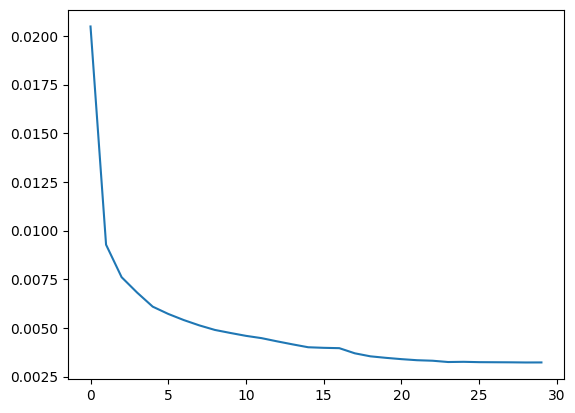

In [63]:
plt.plot(training_loss)

In [64]:
model_path = artifacts_path.joinpath('deeplabv3.resnet101.pth')

In [65]:
torch.save(model.state_dict(), model_path)

In [66]:
get_file_size(model_path)

'222.06MiB'

In [67]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [68]:
from torchmetrics.classification import jaccard

In [69]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


In [70]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.71 
bicycle        : 0.35 
bird           : 0.78 
boat           : 0.63 
bottle         : 0.71 
bus            : 0.83 
car            : 0.75 
cat            : 0.85 
chair          : 0.47 
cow            : 0.77 
diningtable    : 0.71 
dog            : 0.77 
horse          : 0.68 
motorbike      : 0.72 
person         : 0.75 
pottedplant    : 0.4  
sheep          : 0.74 
sofa           : 0.65 
train          : 0.84 
tvmonitor      : 0.72 
----------------------
total          : 0.69 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

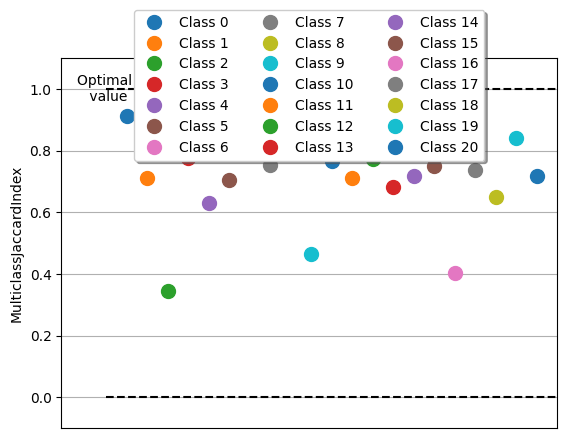

In [71]:
metric.plot()

### for image in dataset

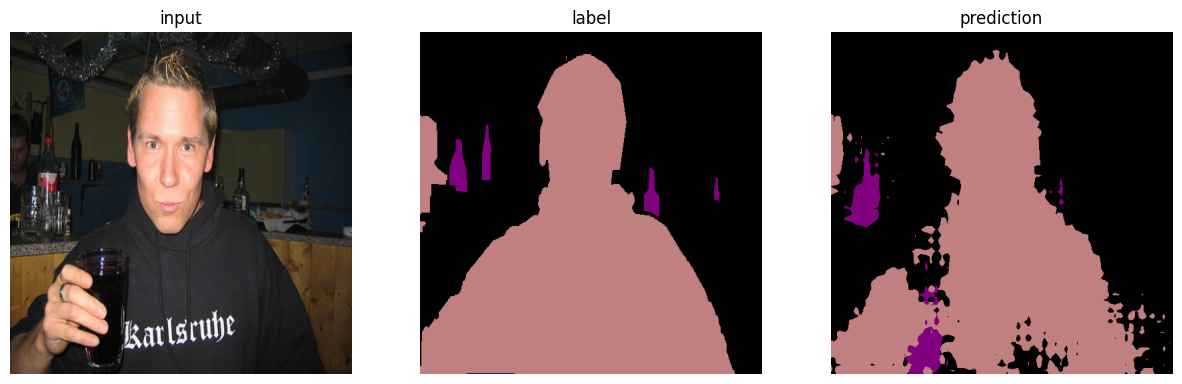

In [72]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

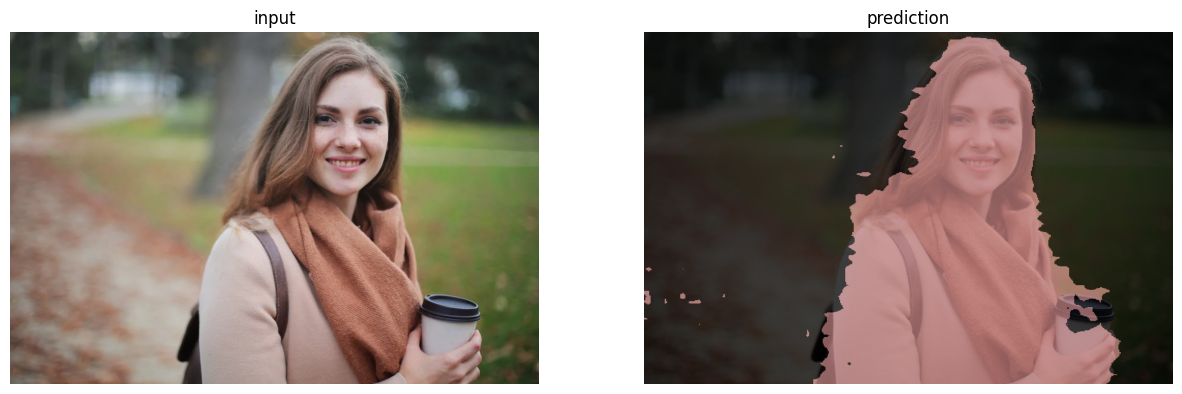

In [73]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )